In [2]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import random
from tqdm import tqdm
import networkx as nx
import seaborn as sns
from tqdm import tqdm
import math
from pylab import rcParams

In [3]:
#adapt the code from classes 
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [4]:
class Farm(): 
    """
    Farm class to store the waste generated by the farm.

    Parameters
    ----------
    n_id : int
        The id of the farm.
    waste : int
        The amount of waste generated by the farm.
    waste_rate_dist : scipy.stats.rv_continuous
        The distribution of the waste rate.
    wait_time_dist : scipy.stats.rv_continuous
        The distribution of the wait time.
    """
    def __init__(self, n_id):
        self.waste = 0 
        self.waste_rate_dist = sts.norm(5, 1)
        self.wait_time_dist = sts.norm(5, 0)
        self.n_id = n_id

    def add_waste(self, new_waste):
        """
        Add waste to the farm.
        """
        self.waste += new_waste
        
    def update_waste(self, recyled_waste):
        """
        Update the waste generated by the farm.
        """
        self.waste -= recyled_waste
        
    def clear_waste(self):
        """
        Clear the waste generated by the farm.
        """
        self.waste = 0        

class Dropoff(): 
    """
    Dropoff class to store the waste generated by the farm.
    """
    def __init__(self, n_id):
        self.id = n_id        

In [5]:
class Truck:
    """
    Truck class that will be used to collect waste from farms and drop it off at the dropoff location
    
    Parameters
    ----------    
    id : int
        The id of the truck.
    max_waste : int
        The maximum amount of waste the truck can hold.
    max_fuel : int
        The maximum amount of fuel the truck can hold.
    cur_fuel : int
        The current amount of fuel the truck has.
    loc : int
        The current location of the truck.
    speed : int
        The speed of the truck.
    fuel_usage_rate : float
        The rate at which the truck uses fuel per km.
    waste : int
        The amount of waste the truck is currently holding.
    all_waste : int
        The total amount of waste the truck has collected.
    all_fuel : int
        The total amount of fuel the truck has used.
    
    """
    def __init__(self, id):
        self.id = id
        self.max_waste = 5
        self.max_fuel = 100
        self.cur_fuel = 100
        self.loc = 0 #depart from hq
        self.speed = 50 #mile/h
        self.fuel_usage_rate = 0.08 #the amount of fuel spending per km 
        self.waste = 0
        self.all_waste = 0 
        self.fuel_use = 0
        
    def get_time(self, distance):
        """
        Get the time it takes to travel a certain distance
        """
        return distance / self.speed
        
    def update_fuel(self, use):
        """
        Update the fuel the truck has
        """
        self.cur_fuel -= use
        self.fuel_use += use
        
    def refuel(self):
        """
        Refuel the truck
        """
        self.cur_fuel = self.max_fuel
                

    def load_waste(self, new_waste): 
        """
        Load waste into the truck
        """
        self.waste += new_waste
        self.all_waste += new_waste

        

In [6]:
class RoadNetwork: 
    """
    RoadNetwork class to store the road network.


    Parameters
    ----------
    g : networkx.Graph
        The graph of the network.    
    num_farms : int
        The number of farms in the network.
    num_dropoff_sites : int
        The number of dropoff sites in the network.
    curr_node_id : int
        The current node id.
    w_min : int
        The minimum amount of distance between two nodes.
    w_max : int
        The maximum amount of distance between two nodes.
    time_load_waste : int
        The time it takes to load waste into the truck.
    colors : dict
        The colors of the nodes.
    n_trucks : int
        The number of trucks in the network.
    drop_time : int
        The time it takes to drop off waste at the dropoff site.
    trucks : list
        The list of trucks in the network.
    farms : list
        The list of farms in the network.
    dropoff_sites : list
        The list of dropoff sites in the network.
    """

    def __init__(self):
        self.g = nx.Graph()
        self.num_farms = 5
        self.num_dropoff_sites = 5
        self.curr_node_id = 1
        self.w_min = 100
        self.w_max = 1000
        self.time_load_waste =  5
        self.colors = {'hq': 'green', 'farm': 'lightblue', 'dropoff': 'y'}
        self.n_trucks = 1
        self.drop_time = 3
        self.trucks = [Truck(id) for id in range(self.n_trucks)]
        self.farms = []
        self.dropoff_sites = []        
        
        self.network_setup()
        self.draw_network()


    def add_hq(self): 
        """
        Add the hq to the network.
        """
        self.g.add_node(0, n_type = 'hq')

    def add_farms(self):
        """
        Add farms to the network.
        """
        new_farm = Farm(self.curr_node_id)
        self.farms.append(new_farm)
        self.g.add_node(self.curr_node_id, n_type = 'farm', 
                        obj = new_farm)
        self.curr_node_id += 1
    
    def add_dropoff_sites(self):
        """
        Add dropoff sites to the network.
        """
        new_dropoff_sites = Dropoff(self.curr_node_id)
        self.dropoff_sites.append(new_dropoff_sites)
        self.g.add_node(self.curr_node_id, n_type = 'dropoff', 
                        obj = new_dropoff_sites)
        self.curr_node_id += 1
    
    def network_setup(self): 
        """
        Setup the network.
        """
        self.add_hq()
        for _ in range(self.num_farms): 
            self.add_farms()
        for _ in range(self.num_dropoff_sites): 
            self.add_dropoff_sites()
        total_nodes = self.num_farms + self.num_dropoff_sites + 1
        #connect all nodes
        for a in range(len(self.g.nodes)):
            for b in range(a+1, len(self.g.nodes)):
                self.g.add_edge(a, b, weight = random.randint(self.w_min, self.w_max))

    def draw_network(self):
        """
        Draw the network.
        """
        rcParams['figure.figsize'] = 14, 10
        pos = nx.spring_layout(self.g, scale=20, k=3/np.sqrt(self.g.order()))
        nx.draw(self.g, pos, 
            with_labels=True, 
            node_color = [self.colors[self.g.nodes[i]['n_type']] for i in self.g.nodes])
        edges_labels = nx.get_edge_attributes(self.g,'weight')
        nx.draw_networkx_edge_labels(self.g,pos,edge_labels=edges_labels)  

        plt.show()
    
    def get_next_farm(self, loc): 
        """
        Get the next farm to go to.

        Parameters
        ----------
        loc: int
            The current truck location
        
        Returns
        -------
        max_waste: int
            The maximum waste of the farms.
        farm_id: int
            The id of the farm with the maximum waste.
        """
        farm_waste_tuples = []
        for i in self.g.neighbors(loc): 
            if self.g.nodes[i]['n_type'] == 'farm': 
                farm_waste_tuples.append((self.g.nodes[i]['obj'].waste, i))
        max_waste, farm_id = max(farm_waste_tuples)
        return max_waste, farm_id

    def get_next_dropoff(self, loc): 
        """
        Get the next dropoff to go to.

        Parameters
        ----------
        loc: int
            The current truck location
        
        Returns
        -------
        next_drop_dist: int
            The distance to the next dropoff.
        dropoff_id: int
            The id of the next dropoff.
        """
        dropoff_tuples = []
        for i in self.g.neighbors(loc): 
            if self.g.nodes[i]['n_type'] == 'dropoff': 
                next_drop_dist = nx.shortest_path_length(self.g, source = loc, target = i, weight = "weight")
                dropoff_tuples.append((next_drop_dist, i))
        next_drop_dist, dropoff_id = min(dropoff_tuples)
        return next_drop_dist, dropoff_id

    def dist_fuel_time_to_hq(self, truck, loc): 
        """
        Get the distance, fuel, and time to the hq.

        Parameters
        ----------
        truck: Truck object
            The truck to get the distance, fuel, and time to the hq.
        loc: int
            The next site location that the truck might visit. 
        
        Returns
        -------
        dist_to_hq: int
            The distance to the hq.
        fuel_to_hq: int
            The fuel to the hq.
        time_to_hq: int
            The time to the hq.
        """
        dist_to_hq = nx.shortest_path_length(self.g, source= loc, target = 0, weight= "weight")
        fuel_to_hq = dist_to_hq * truck.fuel_usage_rate
        time_to_hq = truck.get_time(dist_to_hq)        
        return dist_to_hq, fuel_to_hq, time_to_hq

    def update_trucks(self, schedule): 
        """
        Update the trucks.

        Parameters
        ----------
        schedule: SimPy schedule

        Returns
        -------
        None
        """
        for truck in self.trucks: 
            # print("🚙 update truck count")
            self.truck_depart(schedule, truck) 

    def go_to_droppoff(self, schedule, truck, next_drop_fuel, dropoff_id): 
        """
        Go to the dropoff site.

        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object
        next_drop_fuel: float
            The fuel needed to go to the dropoff site.
        dropoff_id: int
            The id of the dropoff site.
        
        Returns
        -------
        None
        """
        truck.waste = 0 
        truck.loc = dropoff_id
        truck.cur_fuel -= next_drop_fuel
        schedule.add_event_after(
            self.drop_time,
            self.truck_depart, truck)    

    def truck_depart(self, schedule, truck): 
        """
        Truck depart from the current location.
        
        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object

        Returns
        -------
        None
        """

        # if the capacity is full we consider go to the closest drop off sites 
        if truck.waste == truck.max_waste: 
            next_drop_dist, dropoff_id = self.get_next_dropoff(truck.loc)
            next_drop_fuel = next_drop_dist * truck.fuel_usage_rate
            next_drop_time = next_drop_dist/truck.speed
            dist_to_hq, fuel_to_hq, time_to_hq = self.dist_fuel_time_to_hq(truck, dropoff_id)
            # print('dist to hq', dist_to_hq)            
            if  (truck.cur_fuel - next_drop_fuel) <= fuel_to_hq: 
                print("Truck id", truck.id, "go back to HQ to refuel ⛽️ (not drop), cur truck is at loc", truck.loc, ", cur fuel", truck.cur_fuel,", go to dropoff need fuel ", next_drop_fuel, ", go to hq need fuel", fuel_to_hq)
                schedule.add_event_after(
                    time_to_hq, self.go_back_to_hq, truck)  
            else: 
                print(f"🗑 Truck {truck.id} go to dropoff")
                schedule.add_event_after(
                    next_drop_time,
                    self.go_to_droppoff, truck, next_drop_fuel, dropoff_id)

        # if not we consider going to the next farm 
        else:                  
            farm_waste ,farm_id = self.get_next_farm(truck.loc)                
            next_farm_dist = nx.shortest_path_length(self.g, source = truck.loc, target = farm_id, weight = 'weight')
            next_farm_fuel = next_farm_dist * truck.fuel_usage_rate
            next_farm_time = next_farm_dist/truck.speed
            # print("Max waste, farm id", max_waste, farm_id)
            
            dist_to_hq, fuel_to_hq, time_to_hq = self.dist_fuel_time_to_hq(truck, farm_id)
            
            #if we have enough fuel going back to hq after going to the next farm
            if  (truck.cur_fuel - next_farm_fuel) <= fuel_to_hq: 
                print("Truck id", truck.id, "go back to HQ to refuel ⛽️ (not farm), cur truck is at loc", truck.loc, ", cur fuel", truck.cur_fuel,", go to next farm need fuel ", next_farm_fuel, ", go to hq need fuel", fuel_to_hq)
                schedule.add_event_after(
                    time_to_hq, self.go_back_to_hq, truck)        
            else:                 
                schedule.add_event_after(
                    next_farm_time,
                    self.truck_next_farm, truck, next_farm_fuel, farm_id)                

        
    def truck_next_farm(self, schedule, truck, next_farm_fuel, farm_id): 
        """
        Truck go to the next farm.
        
        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object
        next_farm_fuel: float
        farm_id: int

        Returns
        -------
        None
        """
        truck.loc = farm_id
        truck_waste_capacity = truck.max_waste - truck.waste
        farm = self.g.nodes[farm_id]['obj']
        farm_cur_waste = farm.waste
        # print("🐷 Farm cur waste(id: waste)", self.farm_cur_waste())
        print(f"🚛 Truck id {truck.id} go to farm id", farm_id, "with waste", self.g.nodes[farm_id]['obj'].waste, "cur truck waste", truck.waste)
        if truck_waste_capacity <= farm_cur_waste: 
            print(f"    🛑 Truck {truck.id} finishs collecting the waste and reach full waste capacity")
            truck.load_waste(truck_waste_capacity)
            farm.update_waste(truck_waste_capacity)             
        else: 
            truck.load_waste(farm_cur_waste)    
            farm.update_waste(farm_cur_waste)        
        truck.update_fuel(next_farm_fuel)
        
        # print("Update farm waste", farm_id, self.g.nodes[farm_id]['obj'].waste)
        print("🚛 Truck id", truck.id, "Truck loc", truck.loc, "truck updated fuel", truck.cur_fuel, "truck waste", truck.waste)
        schedule.add_event_after(
            self.time_load_waste,
            self.truck_depart, truck)


    def go_back_to_hq(self, schedule, truck): 
        """
        Truck go back to the hq.
        
        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object

        Returns
        -------
        None
        """
        truck.loc = 0
        truck.refuel()     
        schedule.add_event_after(
            5,
            self.truck_depart, truck)     
        print(f"✅ Truck {truck.id} finish refuel in hq and its fuel is", truck.cur_fuel)              
    
    def produce_waste(self, schedule):
        """
        This function makes sure that the farm accumulates waste constantly.
        
        Parameters
        ----------
        schedule: SimPy schedule

        Returns
        -------
        None
        """
        for farm in self.farms: 
            farm.add_waste(2)        
        schedule.add_event_after(
                5,
                self.produce_waste)  
        print("🐷 Farms add waste now, cur waste(id: waste)", self.farm_cur_waste())  

    def run(self, schedule):   
        """
        This function runs the simulation.
        
        Parameters
        ----------
        schedule: SimPy schedule

        Returns
        -------
        None
        """
        schedule.add_event_after(
            0, self.produce_waste)
        schedule.add_event_after(
            0, self.update_trucks)
        
    def farm_cur_waste(self): 
        """
        This function returns the current waste of each farm.
        
        Parameters
        ----------
        None

        Returns
        -------
        farms_tuples: list
            A list of tuples, each tuple contains the farm id and the current waste of the farm.
        """
        farms_tuples =[]
        for farm in self.farms: 
            farms_tuples.append((farm.n_id, farm.waste))
        return farms_tuples
    
    def fuel_use_per_truck(self): 
        """
        This function returns the fuel use of each truck.
        
        Parameters
        ----------
        None

        Returns
        -------
        truck_fuels: list
            A list of tuples, each tuple contains the truck id and the fuel use of the truck.
        """
        truck_fuels = []
        for truck in self.trucks: 
            truck_fuels.append((truck.id, truck.fuel_use))
        return truck_fuels
    
    def waste_collect_per_truck(self): 
        """
        This function returns the waste collected by each truck.

        Parameters
        ----------
        None

        Returns
        -------
        truck_waste: list
            A list of tuples, each tuple contains the truck id and the all the waste collected by the truck.
        """
        truck_waste = []
        for truck in self.trucks: 
            truck_waste.append((truck.id, truck.all_waste))
        return truck_waste        
        

In [7]:
import random

random.seed(10)

## Code testing with simple case

In order to check if our code is correct, we set up a simple case and print it out. Here are our initial setup for the east of code testing 
- 5 farms
- fixed waste production of farms (2 unit of waste per 5 hr)
- 1 trucks
- Truck max fuel capacity = 100 
- Truck max waste capacity = 5
- Run the schedule for only 30 hr
- strategy: go to the farm with the max waste for the current truck

You can see the ouput with the final statistics.

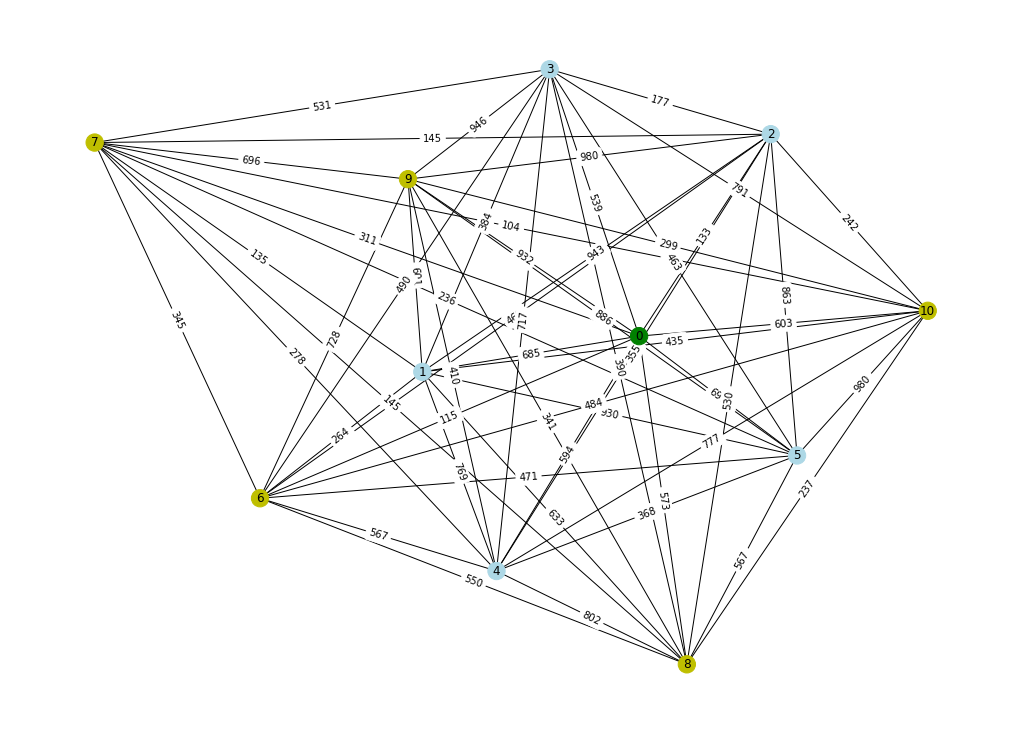

🐷 Farms add waste now, cur waste(id: waste) [(1, 2), (2, 2), (3, 2), (4, 2), (5, 2)]
🐷 Farms add waste now, cur waste(id: waste) [(1, 4), (2, 4), (3, 4), (4, 4), (5, 4)]
🐷 Farms add waste now, cur waste(id: waste) [(1, 6), (2, 6), (3, 6), (4, 6), (5, 6)]
🚛 Truck id 0 go to farm id 5 with waste 6 cur truck waste 0
    🛑 Truck 0 finishs collecting the waste and reach full waste capacity
🚛 Truck id 0 Truck loc 5 truck updated fuel 58.88 truck waste 5
🐷 Farms add waste now, cur waste(id: waste) [(1, 8), (2, 8), (3, 8), (4, 8), (5, 3)]
🗑 Truck 0 go to dropoff
🐷 Farms add waste now, cur waste(id: waste) [(1, 10), (2, 10), (3, 10), (4, 10), (5, 5)]
Truck id 0 go back to HQ to refuel ⛽️ (not farm), cur truck is at loc 7 , cur fuel 40.0 , go to next farm need fuel  22.240000000000002 , go to hq need fuel 39.04
🐷 Farms add waste now, cur waste(id: waste) [(1, 12), (2, 12), (3, 12), (4, 12), (5, 7)]
🐷 Farms add waste now, cur waste(id: waste) [(1, 14), (2, 14), (3, 14), (4, 14), (5, 9)]
✅ Truck 0

In [8]:
schedule = Schedule()
road_network = RoadNetwork()
road_network.run(schedule)
while schedule.now <= 35:
    schedule.run_next_event()
    # schedule.print_events()
print()
print("🎯 Final statistics 🎯")
print("farm current waste (farm id: waste)", road_network.farm_cur_waste())
print("fuel_use_per_truck (truck id: fuel)", road_network.fuel_use_per_truck())
print("waste_collect_per_truck (truck id: waste)", road_network.waste_collect_per_truck())


## Run simulation

In [9]:
class Farm(): 
    """
    Farm class to store the waste generated by the farm.

    Parameters
    ----------
    n_id : int
        The id of the farm.
    waste : int
        The amount of waste generated by the farm.
    waste_rate_dist : scipy.stats.rv_continuous
        The distribution of the waste rate.
    """
    def __init__(self, n_id):
        self.waste = 0 
        self.waste_rate_dist = sts.halfcauchy(0, 5)
        self.n_id = n_id

    def add_waste(self, new_waste):
        """
        Add waste to the farm.
        """
        self.waste += new_waste
        
    def update_waste(self, recyled_waste):
        """
        Update the waste generated by the farm.
        """
        self.waste -= recyled_waste
        
    def clear_waste(self):
        """
        Clear the waste generated by the farm.
        """
        self.waste = 0        

class Dropoff(): 
    """
    Dropoff class to store the waste generated by the farm.
    """
    def __init__(self, n_id):
        self.id = n_id        

In [10]:
class Truck:
    """
    Truck class that will be used to collect waste from farms and drop it off at the dropoff location
    
    Parameters
    ----------    
    id : int
        The id of the truck.
    max_waste : int
        The maximum amount of waste the truck can hold.
    max_fuel : int
        The maximum amount of fuel the truck can hold.
    cur_fuel : int
        The current amount of fuel the truck has.
    loc : int
        The current location of the truck.
    speed : int
        The speed of the truck.
    fuel_usage_rate : float
        The rate at which the truck uses fuel per km.
    waste : int
        The amount of waste the truck is currently holding.
    all_waste : int
        The total amount of waste the truck has collected.
    all_fuel : int
        The total amount of fuel the truck has used.
    
    """
    def __init__(self, id):
        self.id = id
        self.max_waste = 2800
        self.max_fuel = 150
        self.cur_fuel = 150
        self.loc = 0 #depart from hq
        self.speed = sts.norm(50, 5)
        self.fuel_usage_rate = 0.08 #the amount of fuel spending per km 
        self.waste = 0
        self.all_waste = 0 
        self.fuel_use = 0
        
    def get_time(self, distance):
        """
        Get the time it takes to travel a certain distance
        """
        return distance / self.speed.rvs()
        
    def update_fuel(self, use):
        """
        Update the fuel the truck has
        """
        self.cur_fuel -= use
        self.fuel_use += use
        
    def refuel(self):
        """
        Refuel the truck
        """
        self.cur_fuel = self.max_fuel
                

    def load_waste(self, new_waste): 
        """
        Load waste into the truck
        """
        self.waste += new_waste
        self.all_waste += new_waste

        

In [91]:
class RoadNetwork: 
    """
    RoadNetwork class to store the road network.


    Parameters
    ----------
    g : networkx.Graph
        The graph of the network.    
    num_farms : int
        The number of farms in the network.
    num_dropoff_sites : int
        The number of dropoff sites in the network.
    curr_node_id : int
        The current node id.
    w_min : int
        The minimum amount of distance between two nodes.
    w_max : int
        The maximum amount of distance between two nodes.
    time_load_waste : int
        The time it takes to load waste into the truck.
    colors : dict
        The colors of the nodes.
    n_trucks : int
        The number of trucks in the network.
    drop_time : int
        The time it takes to drop off waste at the dropoff site.
    trucks : list
        The list of trucks in the network.
    farms : list
        The list of farms in the network.
    dropoff_sites : list
        The list of dropoff sites in the network.
    strategy : str
        The strategy used to determine which farm to visit next.
    produce_waste_time : int
        The time it takes to produce waste at the farm.
    visited_farms : int
        The number of farms visited.
    visited_dropoff_sites : int
        The number of dropoff sites visited.
    visited_hq : int
        The number of times the truck has visited the hq.
    """

    def __init__(self, num_farms, num_dropoff_sites, n_trucks, strategy):
        self.g = nx.Graph()
        self.num_farms = num_farms
        self.num_dropoff_sites = num_dropoff_sites
        self.curr_node_id = 1
        self.w_min = 100
        self.w_max = 1500
        self.time_load_waste = sts.norm(5, 0.1)
        self.colors = {'hq': 'green', 'farm': 'lightblue', 'dropoff': 'y'}
        self.n_trucks = n_trucks
        self.strategy = 'max_waste'
        self.drop_time = sts.norm(3, 0.1)
        self.produce_waste_time = sts.norm(5, 0.1)
        self.trucks = [Truck(id) for id in range(self.n_trucks)]
        self.farms = []
        self.dropoff_sites = []        
        self.visited_hq = 0 
        self.visited_farms = 0
        self.visited_dropoff = 0
        
        self.network_setup()
        # self.draw_network()


    def add_hq(self): 
        """
        Add the hq to the network.
        """
        self.g.add_node(0, n_type = 'hq')

    def add_farms(self):
        """
        Add farms to the network.
        """
        new_farm = Farm(self.curr_node_id)
        self.farms.append(new_farm)
        self.g.add_node(self.curr_node_id, n_type = 'farm', 
                        obj = new_farm)
        self.curr_node_id += 1
    
    def add_dropoff_sites(self):
        """
        Add dropoff sites to the network.
        """
        new_dropoff_sites = Dropoff(self.curr_node_id)
        self.dropoff_sites.append(new_dropoff_sites)
        self.g.add_node(self.curr_node_id, n_type = 'dropoff', 
                        obj = new_dropoff_sites)
        self.curr_node_id += 1
    
    def network_setup(self): 
        """
        Setup the network.
        """
        self.add_hq()
        for _ in range(self.num_farms): 
            self.add_farms()
        for _ in range(self.num_dropoff_sites): 
            self.add_dropoff_sites()
        total_nodes = self.num_farms + self.num_dropoff_sites + 1
        #connect all nodes
        for a in range(len(self.g.nodes)):
            for b in range(a+1, len(self.g.nodes)):
                self.g.add_edge(a, b, weight = random.randint(self.w_min, self.w_max))

    def draw_network(self):
        """
        Draw the network.
        """
        node_sizes = []
        for node_id in self.g.nodes: 
            if self.g.nodes[node_id]['n_type'] == 'farm':
                node_sizes.append(road_network.g.nodes[node_id]['obj'].waste * 10 + 200)
            elif self.g.nodes[node_id]['n_type'] == 'dropoff':
                node_sizes.append(200)
            elif self.g.nodes[node_id]['n_type'] == 'hq':
                node_sizes.append(500)

        pos = nx.spring_layout(self.g, scale=20, k=3/np.sqrt(self.g.order()))
        nx.draw(self.g, pos, 
            with_labels=True, 
            node_color = [self.colors[road_network.g.nodes[i]['n_type']] for i in self.g.nodes], 
            node_size= node_sizes)
        edges_labels = nx.get_edge_attributes(self.g,'weight')
        nx.draw_networkx_edge_labels(self.g,pos,edge_labels=edges_labels)   
        plt.show()
    
    def get_next_farm(self, loc): 
        """
        Get the next farm to go to.

        Parameters
        ----------
        loc: int
            The current truck location
        
        Returns
        -------
        waste: int
            The waste of the selected farm.
        farm_id: int
            The id of the selected farm
        """
        farm_waste_tuples = []


        for i in self.g.neighbors(loc): 
            if self.g.nodes[i]['n_type'] == 'farm': 
                farm_waste_tuples.append((self.g.nodes[i]['obj'].waste, i))
        
        if self.strategy == 'max_waste': 
            max_waste, farm_id = max(farm_waste_tuples)
            return max_waste, farm_id
        elif self.strategy == 'random':
            random_waste, farm_id = random.choice(farm_waste_tuples)
            return random_waste, farm_id

        elif self.strategy == 'closest_farm': 
            farm_dist_tuples = []
            for i in self.g.neighbors(loc): 
                if self.g.nodes[i]['n_type'] == 'farm': 
                    farm_dist_tuples.append((nx.shortest_path_length(self.g, source = loc, target = i, weight = "weight"), i))
            min_dist_waste, farm_id = min(farm_dist_tuples)
            return min_dist_waste, farm_id


    def get_next_dropoff(self, loc): 
        """
        Get the next dropoff to go to.

        Parameters
        ----------
        loc: int
            The current truck location
        
        Returns
        -------
        next_drop_dist: int
            The distance to the next dropoff.
        dropoff_id: int
            The id of the next dropoff.
        """        
        dropoff_tuples = []
        for i in self.g.neighbors(loc): 
            if self.g.nodes[i]['n_type'] == 'dropoff': 
                next_drop_dist = nx.shortest_path_length(self.g, source = loc, target = i, weight = "weight")
                dropoff_tuples.append((next_drop_dist, i))
        next_drop_dist, dropoff_id = min(dropoff_tuples)
        return next_drop_dist, dropoff_id

    def dist_fuel_time_to_hq(self, truck, loc): 
        """
        Get the distance, fuel, and time to the hq.

        Parameters
        ----------
        truck: Truck object
            The truck to get the distance, fuel, and time to the hq.
        loc: int
            The next site location that the truck might visit. 
        
        Returns
        -------
        dist_to_hq: int
            The distance to the hq.
        fuel_to_hq: int
            The fuel to the hq.
        time_to_hq: int
            The time to the hq.
        """
        dist_to_hq = nx.shortest_path_length(self.g, source= loc, target = 0, weight= "weight")
        fuel_to_hq = dist_to_hq * truck.fuel_usage_rate
        time_to_hq = truck.get_time(dist_to_hq)        
        return dist_to_hq, fuel_to_hq, time_to_hq

    def update_trucks(self, schedule): 
        """
        Update the trucks.

        Parameters
        ----------
        schedule: SimPy schedule

        Returns
        -------
        None
        """
        for truck in self.trucks: 
            # print("🚙 update truck count")
            self.truck_depart(schedule, truck) 

    def go_to_droppoff(self, schedule, truck, next_drop_fuel, dropoff_id): 
        """
        Go to the dropoff site.

        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object
        next_drop_fuel: float
            The fuel needed to go to the dropoff site.
        dropoff_id: int
            The id of the dropoff site.
        
        Returns
        -------
        None
        """
        self.visited_dropoff += 1
        truck.waste = 0 
        truck.loc = dropoff_id
        truck.cur_fuel -= next_drop_fuel
        schedule.add_event_after(
            self.drop_time.rvs(),
            self.truck_depart, truck)    

    def truck_depart(self, schedule, truck): 
        """
        Truck depart from the current location.
        
        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object

        Returns
        -------
        None
        """

        # if the capacity is full we consider go to the closest drop off sites 
        if truck.waste == truck.max_waste: 
            next_drop_dist, dropoff_id = self.get_next_dropoff(truck.loc)
            next_drop_fuel = next_drop_dist * truck.fuel_usage_rate
            next_drop_time = next_drop_dist/truck.speed.rvs()
            dist_to_hq, fuel_to_hq, time_to_hq = self.dist_fuel_time_to_hq(truck, dropoff_id)
            # print('dist to hq', dist_to_hq)            
            if  (truck.cur_fuel - next_drop_fuel) <= fuel_to_hq: 
                # print("Truck id", truck.id, "go back to HQ to refuel ⛽️ (not drop), cur truck is at loc", truck.loc, ", cur fuel", truck.cur_fuel,", go to dropoff need fuel ", next_drop_fuel, ", go to hq need fuel", fuel_to_hq)
                schedule.add_event_after(
                    time_to_hq, self.go_back_to_hq, truck)  
            else: 
                # print(f"🗑 Truck {truck.id} go to dropoff")
                schedule.add_event_after(
                    next_drop_time,
                    self.go_to_droppoff, truck, next_drop_fuel, dropoff_id)

        # if not we consider going to the next farm 
        else:                  
            farm_waste ,farm_id = self.get_next_farm(truck.loc)                
            next_farm_dist = nx.shortest_path_length(self.g, source = truck.loc, target = farm_id, weight = 'weight')
            next_farm_fuel = next_farm_dist * truck.fuel_usage_rate
            next_farm_time = next_farm_dist/truck.speed.rvs()
            # print("Max waste, farm id", max_waste, farm_id)
            
            dist_to_hq, fuel_to_hq, time_to_hq = self.dist_fuel_time_to_hq(truck, farm_id)
            
            #if we have enough fuel going back to hq after going to the next farm
            if  (truck.cur_fuel - next_farm_fuel) <= fuel_to_hq: 
                # print("Truck id", truck.id, "go back to HQ to refuel ⛽️ (not farm), cur truck is at loc", truck.loc, ", cur fuel", truck.cur_fuel,", go to next farm need fuel ", next_farm_fuel, ", go to hq need fuel", fuel_to_hq)
                schedule.add_event_after(
                    time_to_hq, self.go_back_to_hq, truck)        
            else:                 
                schedule.add_event_after(
                    next_farm_time,
                    self.truck_next_farm, truck, next_farm_fuel, farm_id)                

        
    def truck_next_farm(self, schedule, truck, next_farm_fuel, farm_id): 
        """
        Truck go to the next farm.
        
        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object
        next_farm_fuel: float
        farm_id: int

        Returns
        -------
        None
        """
        self.visited_farms += 1
        truck.loc = farm_id
        truck_waste_capacity = truck.max_waste - truck.waste
        farm = self.g.nodes[farm_id]['obj']
        farm_cur_waste = farm.waste
        # print("🐷 Farm cur waste(id: waste)", self.farm_cur_waste())
        # print(f"🚛 Truck id {truck.id} go to farm id", farm_id, "with waste", self.g.nodes[farm_id]['obj'].waste, "cur truck waste", truck.waste)
        if truck_waste_capacity <= farm_cur_waste: 
            # print(f"    🛑 Truck {truck.id} finishs collecting the waste and reach full waste capacity")
            truck.load_waste(truck_waste_capacity)
            farm.update_waste(truck_waste_capacity)             
        else: 
            truck.load_waste(farm_cur_waste)    
            farm.update_waste(farm_cur_waste)        
        truck.update_fuel(next_farm_fuel)
        
        # print("Update farm waste", farm_id, self.g.nodes[farm_id]['obj'].waste)
        # print("🚛 Truck id", truck.id, "Truck loc", truck.loc, "truck updated fuel", truck.cur_fuel, "truck waste", truck.waste)
        schedule.add_event_after(
            self.time_load_waste.rvs(),
            self.truck_depart, truck)


    def go_back_to_hq(self, schedule, truck): 
        """
        Truck go back to the hq.
        
        Parameters
        ----------
        schedule: SimPy schedule
        truck: Truck object

        Returns
        -------
        None
        """
        self.visited_hq += 1
        truck.loc = 0
        truck.refuel()     
        schedule.add_event_after(
            5,
            self.truck_depart, truck)     
        # print(f"✅ Truck {truck.id} finish refuel in hq and its fuel is", truck.cur_fuel)              
    
    def produce_waste(self, schedule):
        """
        This function makes sure that the farm accumulates waste constantly.
        
        Parameters
        ----------
        schedule: SimPy schedule

        Returns
        -------
        None
        """
        for farm in self.farms: 
            farm.add_waste(farm.waste_rate_dist.rvs())        
        schedule.add_event_after(
                self.produce_waste_time.rvs(),
                self.produce_waste)  
        # print("🐷 Farms add waste now, cur waste(id: waste)", self.farm_cur_waste())  

    def run(self, schedule):   
        """
        This function runs the simulation.
        
        Parameters
        ----------
        schedule: SimPy schedule

        Returns
        -------
        None
        """
        schedule.add_event_after(
            0, self.produce_waste)
        schedule.add_event_after(
            0, self.update_trucks)
        
    def farm_cur_waste(self): 
        """
        This function returns the current waste of each farm.
        
        Parameters
        ----------
        None

        Returns
        -------
        farms_tuples: list
            A list of tuples, each tuple contains the farm id and the current waste of the farm.
        """
        farms_tuples ={}
        for farm in self.farms: 
            farms_tuples[farm.n_id] = farm.waste
        return farms_tuples
    
    def fuel_use_per_truck(self): 
        """
        This function returns the fuel use of each truck.
        
        Parameters
        ----------
        None

        Returns
        -------
        truck_fuels: list
            A list of tuples, each tuple contains the truck id and the fuel use of the truck.
        """
        truck_fuels = {}
        for truck in self.trucks: 
            truck_fuels[truck.id] = truck.fuel_use
        return truck_fuels
    
    def waste_collect_per_truck(self): 
        """
        This function returns the waste collected by each truck.

        Parameters
        ----------
        None

        Returns
        -------
        truck_waste: list
            A list of tuples, each tuple contains the truck id and the all the waste collected by the truck.
        """
        truck_waste = {}
        for truck in self.trucks: 
            truck_waste[truck.id] = truck.all_waste
        return truck_waste        
        

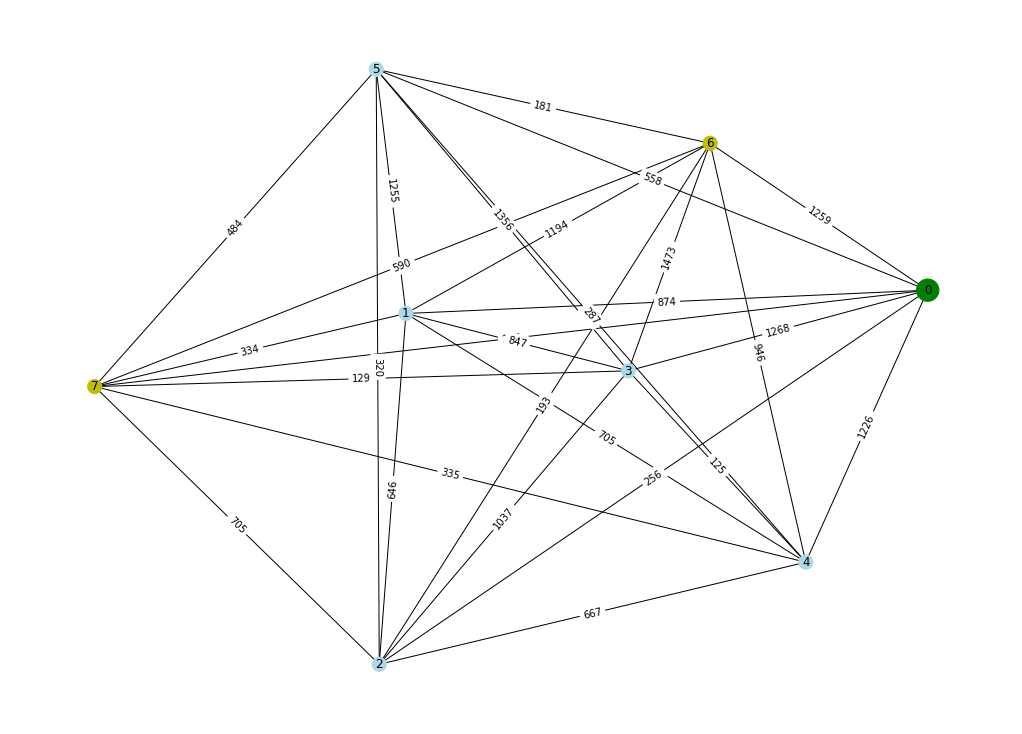


🎯 Final statistics 🎯
farm current waste (farm id: waste) {1: 10.33335784231795, 2: 75.15831068407432, 3: 152.53372681466578, 4: 0.0, 5: 586.4139386044375}
fuel_use_per_truck (truck id: fuel) {0: 1685.9999999999998, 1: 1716.3200000000002, 2: 1646.1600000000003, 3: 1722.0800000000004, 4: 1742.9599999999998}
waste_collect_per_truck (truck id: waste) {0: 2800.0, 1: 7970.758239747946, 2: 8111.55588813045, 3: 3359.9503334275582, 4: 5628.905326142811}


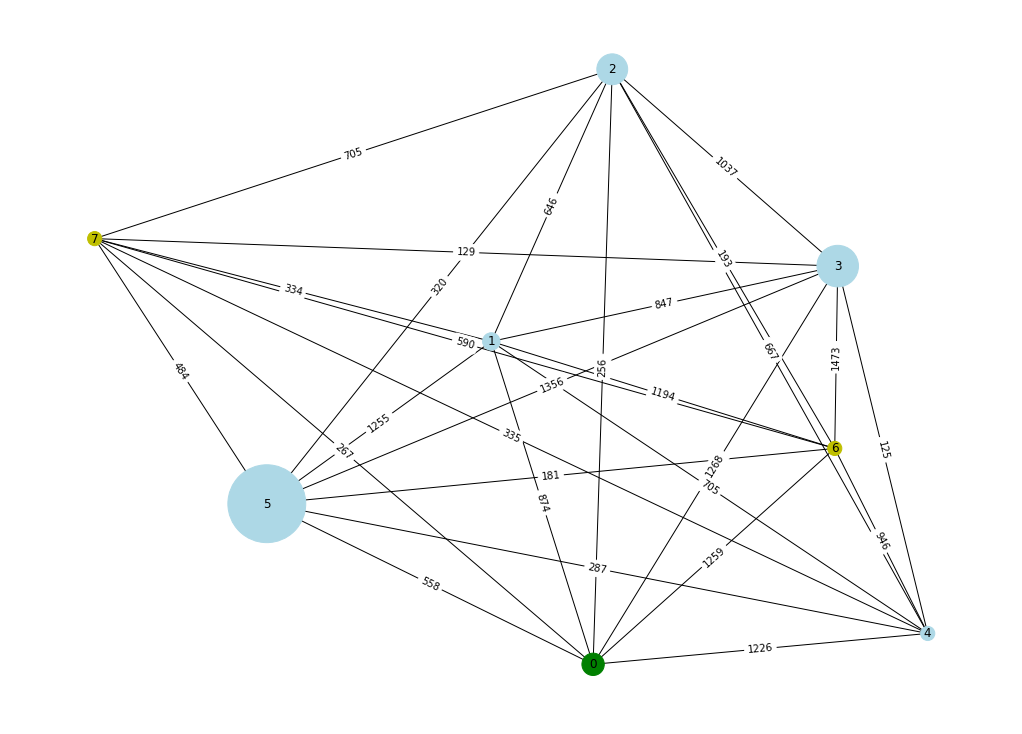

In [89]:
num_farms = 5
num_dropoff_sites = 2
n_trucks = 5

collected_total_wastes = []
schedule = Schedule()
road_network = RoadNetwork(num_farms, num_dropoff_sites, n_trucks, strategy = 'max_waste')
road_network.run(schedule)
road_network.draw_network()
run = 0 
time = []
while schedule.now <= 1000:
    run += 1
    schedule.run_next_event()
    if run % 10 == 0:
        time.append(schedule.now)
        collected_total_wastes.append(sum(road_network.waste_collect_per_truck().values()))
print()
print("🎯 Final statistics 🎯")
print("farm current waste (farm id: waste)", road_network.farm_cur_waste())
print("fuel_use_per_truck (truck id: fuel)", road_network.fuel_use_per_truck())
print("waste_collect_per_truck (truck id: waste)", road_network.waste_collect_per_truck())

road_network.draw_network()

## Animate farm waste 

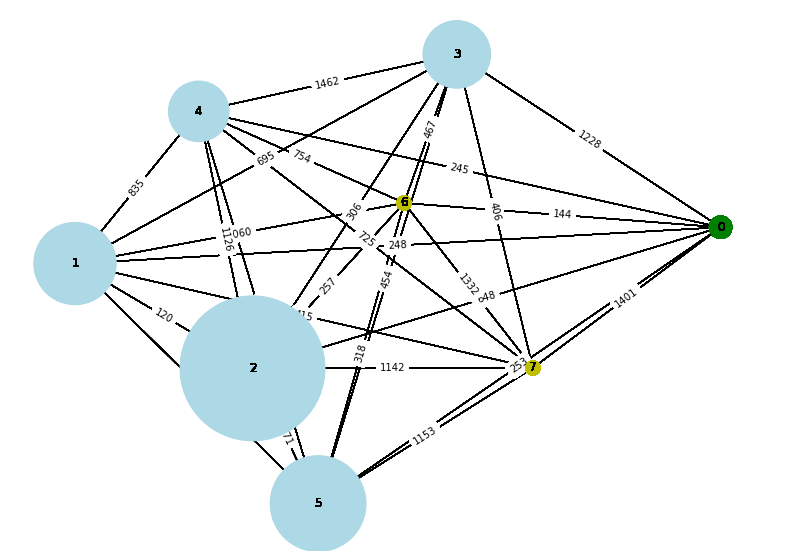

In [94]:
from matplotlib import animation
from IPython.display import HTML

num_farms = 5
num_dropoff_sites = 2
n_trucks = 5


schedule = Schedule()
road_network = RoadNetwork(num_farms, num_dropoff_sites, n_trucks, strategy = 'max_waste')
road_network.run(schedule)


def simple_update(n):
    while schedule.now <= n*10:
        schedule.run_next_event()      
    node_sizes = []
    for node_id in road_network.g.nodes: 
        if road_network.g.nodes[node_id]['n_type'] == 'farm':
            node_sizes.append(road_network.g.nodes[node_id]['obj'].waste * 10 + 200)
        elif road_network.g.nodes[node_id]['n_type'] == 'dropoff':
            node_sizes.append(200)
        elif road_network.g.nodes[node_id]['n_type'] == 'hq':
            node_sizes.append(500)

    pos = nx.spring_layout(road_network.g, scale=20, k=3/np.sqrt(road_network.g.order()), seed = 1)
    nx.draw(road_network.g, pos, 
        with_labels=True, 
        node_color = [road_network.colors[road_network.g.nodes[i]['n_type']] for i in road_network.g.nodes], 
        node_size= node_sizes)
    edges_labels = nx.get_edge_attributes(road_network.g,'weight')
    plot = nx.draw_networkx_edge_labels(road_network.g,pos,edge_labels=edges_labels)   
    return plot


def simple_animation():
    fig, ax = plt.subplots()
    rcParams['figure.figsize'] = 14, 10
    ani = animation.FuncAnimation(fig, simple_update, frames = 100, interval=100, repeat=False)
    output = HTML(ani.to_html5_video())
    return output

simple_animation()

In [14]:
road_network.visited_hq, road_network.visited_farms, road_network.visited_dropoff

(112, 135, 5)

Text(0, 0.5, 'Total waste collected')

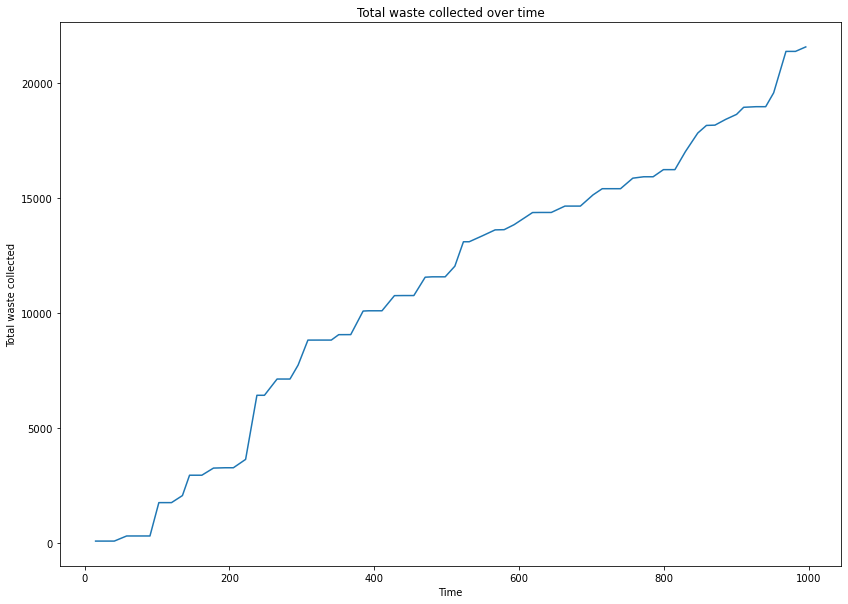

In [15]:
plt.plot(time, collected_total_wastes)
plt.title("Total waste collected over time")
plt.xlabel("Time")
plt.ylabel("Total waste collected")

In [274]:
trials = 300
num_farms = 50
num_dropoff_sites = 10
n_trucks = 5
def experiment(trials, num_farms, num_dropoff_sites, n_trucks, strategy):     
    collected_total_wastes = []    
    total_fuels = []    
    total_profits = []
    visited_hq = []
    visited_farms = []
    visited_dropoff = []

    for _ in tqdm(range(trials)):
        
        schedule = Schedule()
        road_network = RoadNetwork(num_farms, num_dropoff_sites, n_trucks, strategy)
        road_network.run(schedule)
        while schedule.now <= 1000:
            schedule.run_next_event()
                
        sum_waste = sum(road_network.waste_collect_per_truck().values())
        sum_fuel = sum(road_network.fuel_use_per_truck().values())
        profit = sum_waste *200 - sum_fuel*0.25
        collected_total_wastes.append(sum_waste)
        total_fuels.append(sum_fuel)
        total_profits.append(profit)

        visited_hq.append(road_network.visited_hq)
        visited_farms.append(road_network.visited_farms)
        visited_dropoff.append(road_network.visited_dropoff)
    


    return collected_total_wastes, total_fuels, total_profits, np.mean(visited_hq), np.mean(visited_farms), np.mean(visited_dropoff)

max_waste_total_wastes, max_waste_total_fuels, max_waste_total_profits, max_visited_hq, max_visited_farms,max_visited_dropoff  = experiment(trials, num_farms, num_dropoff_sites, n_trucks, 'max_waste')
random_total_wastes, random_total_fuels, random_total_profits, random_visited_hq, random_visited_farms, random_visited_dropoff = experiment(trials, num_farms, num_dropoff_sites, n_trucks, 'random')
closest_farm_total_wastes, closest_total_fuels, closest_total_profits, closest_visited_hq, closest_random_visited_farms, closest_visited_dropoff = experiment(trials, num_farms, num_dropoff_sites, n_trucks, 'closest_farm')

100%|██████████| 300/300 [07:43<00:00,  1.55s/it]


In [285]:
print('Max strategy: count visited hq', max_visited_hq, ", count visited farms", max_visited_farms, ", count visited dropoff", max_visited_dropoff)
print('Random strategy: count visited hq', random_visited_hq, ", count visited farms", random_visited_farms, ", count visited dropoff", random_visited_dropoff)
print('Closest farm strategy: count visited hq', closest_visited_hq, ", count visited farms", closest_random_visited_farms, ", count visited dropoff", closest_visited_dropoff)

Max strategy: count visited hq 81.99333333333334 , count visited farms 273.28 , count visited dropoff 98.83333333333333
Random strategy: count visited hq 81.92 , count visited farms 272.56666666666666 , count visited dropoff 99.79333333333334
Closest farm strategy: count visited hq 81.46333333333334 , count visited farms 274.15 , count visited dropoff 102.43


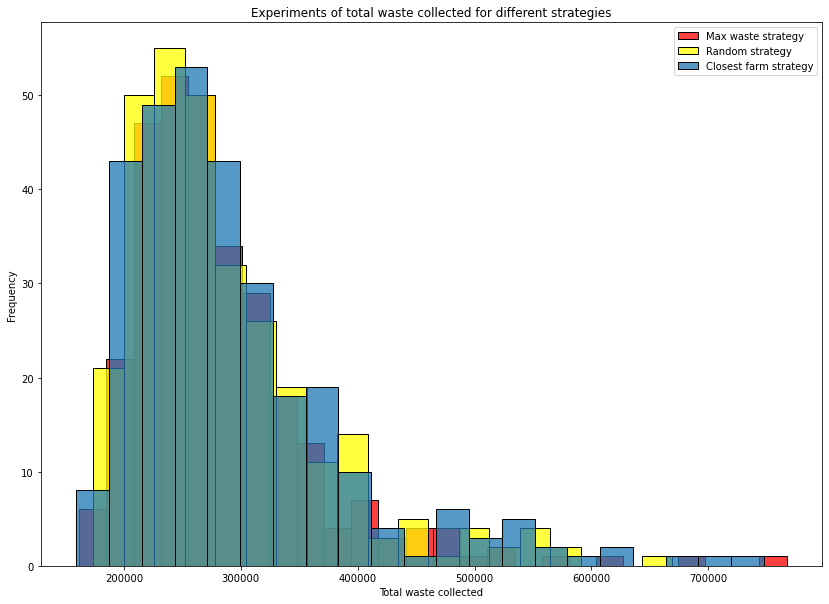

In [276]:
sns.histplot(max_waste_total_wastes, label="Max waste strategy", color = 'red')
sns.histplot(random_total_wastes, label = "Random strategy", color = 'yellow')
sns.histplot(closest_farm_total_wastes, label = "Closest farm strategy")
plt.title("Experiments of total waste collected for different strategies")
plt.ylabel("Frequency")
plt.xlabel("Total waste collected")
plt.legend()

Text(0, 0.5, 'Total waste collected')

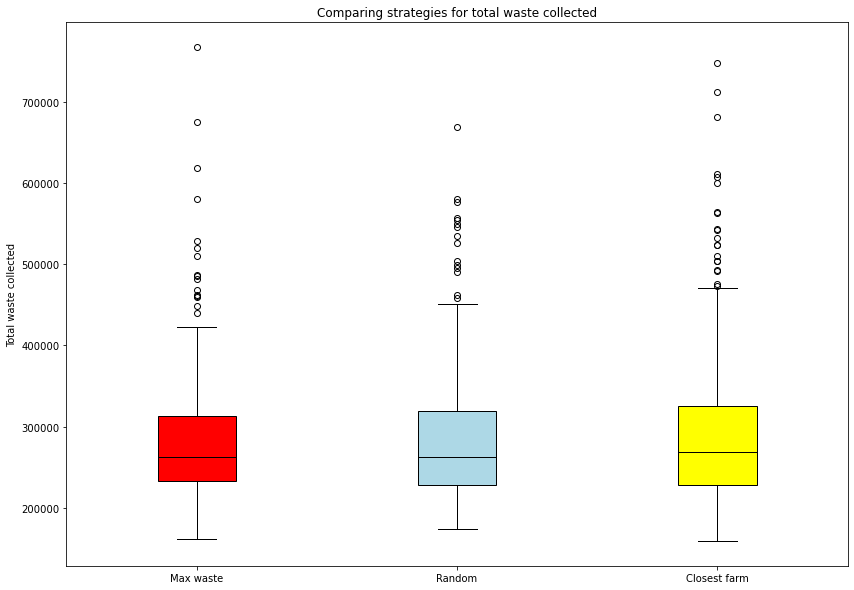

In [277]:
def boxplot(max_waste, random, closest_farm):
     fig, ax = plt.subplots()
     x = [max_waste,random, closest_farm]
     palette = ['red', 'lightblue', 'yellow']
     box = ax.boxplot(x, patch_artist=True) 
     for patch, color in zip(box['boxes'], palette):
          patch.set_facecolor(color)
     for median in box['medians']:
          median.set_color('black')
     ax.set_xticklabels(["Max waste", "Random", "Closest farm"])

boxplot(max_waste_total_wastes, random_total_wastes, closest_farm_total_wastes)   
plt.title("Comparing strategies for total waste collected")
plt.ylabel("Total waste collected")

In [278]:
def statistics_cal(variable, max_waste, random, closest_farm):
    print(f'Average {variable} for max waste strategy ', round(np.mean(max_waste)), 'and its std', round(np.std(max_waste)))
    print('     Its confidence interval is', sts.t.interval(0.95, len(max_waste)-1, loc=np.mean(max_waste), scale=sts.sem(max_waste)))
    print(f'Average {variable} for random strategy ', round(np.mean(random)), 'and its std', round(np.std(random)))
    print('     Its confidence interval is', sts.t.interval(0.95, len(random)-1, loc=np.mean(random), scale=sts.sem(random)))
    print(f'Average {variable} for closest farm strategy ', round(np.mean(closest_farm)), 'and its std', round(np.std(closest_farm)))
    print('     Its confidence interval is', sts.t.interval(0.95, len(closest_farm)-1, loc=np.mean(closest_farm), scale=sts.sem(closest_farm)))
    
statistics_cal('waste', max_waste_total_wastes, random_total_wastes, closest_farm_total_wastes)


Average waste for max waste strategy  283046 and its std 79917
     Its confidence interval is (273950.73570297076, 292141.06920519273)
Average waste for random strategy  285726 and its std 82845
     Its confidence interval is (276297.25391608546, 295154.05743705237)
Average waste for closest farm strategy  293326 and its std 94959
     Its confidence interval is (282519.07079111354, 304133.26217652345)


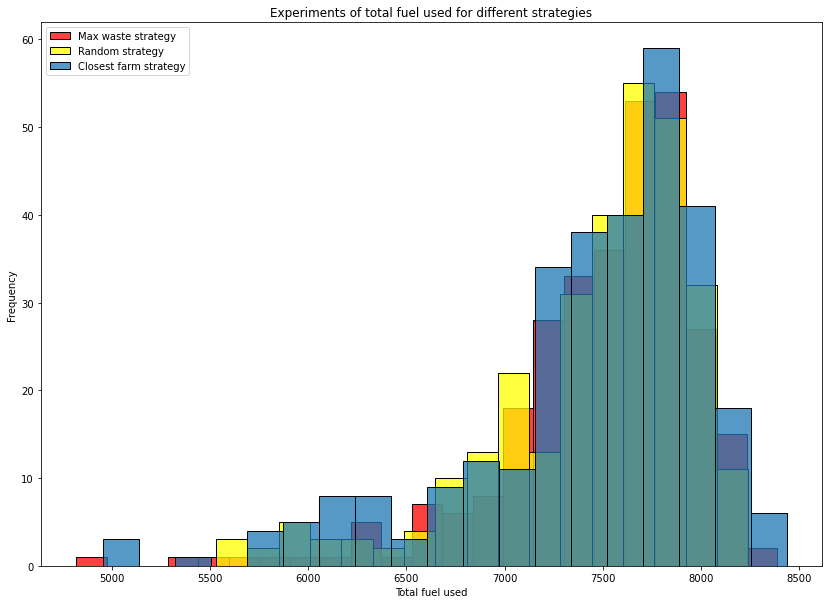

In [279]:
sns.histplot(max_waste_total_fuels, label="Max waste strategy", color = 'red')
sns.histplot(random_total_fuels, label = "Random strategy", color = 'yellow')
sns.histplot(closest_total_fuels, label = "Closest farm strategy")
plt.title("Experiments of total fuel used for different strategies")
plt.ylabel("Frequency")
plt.xlabel("Total fuel used")
plt.legend()

Average fuel used for max waste strategy  7498 and its std 502
     Its confidence interval is (7440.874711172665, 7555.106088827336)
Average fuel used for random strategy  7451 and its std 526
     Its confidence interval is (7390.771179849276, 7510.459753484058)
Average fuel used for closest farm strategy  7436 and its std 620
     Its confidence interval is (7365.750707033354, 7506.9570262999805)


Text(0, 0.5, 'Total fuel used')

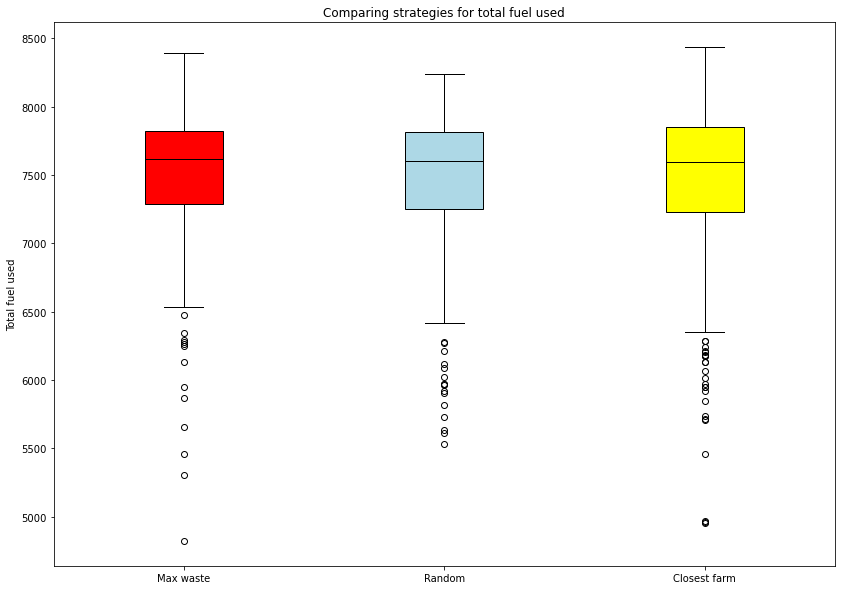

In [280]:
statistics_cal('fuel used', max_waste_total_fuels, random_total_fuels, closest_total_fuels)
boxplot(max_waste_total_fuels, random_total_fuels, closest_total_fuels)  
plt.title("Comparing strategies for total fuel used")
plt.ylabel("Total fuel used")

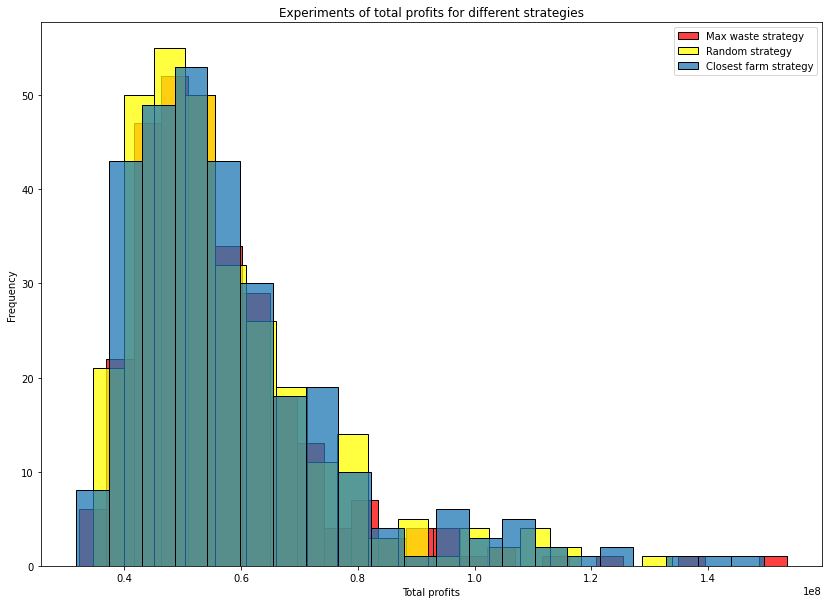

In [281]:
sns.histplot(max_waste_total_profits, label="Max waste strategy", color = 'red')
sns.histplot(random_total_profits, label = "Random strategy", color = 'yellow')
sns.histplot(closest_total_profits, label = "Closest farm strategy")
plt.title("Experiments of total profits for different strategies")
plt.ylabel("Frequency")
plt.xlabel("Total profits")
plt.legend()

Average profits for max waste strategy  56607306 and its std 15983426
     Its confidence interval is (54788259.278452836, 58426352.707979865)
Average profits for random strategy  57143268 and its std 16569040
     Its confidence interval is (55257573.98302912, 59028962.979865156)
Average profits for closest farm strategy  58663374 and its std 18991899
     Its confidence interval is (56501938.25489457, 60824810.16169949)


Text(0, 0.5, 'Total profits')

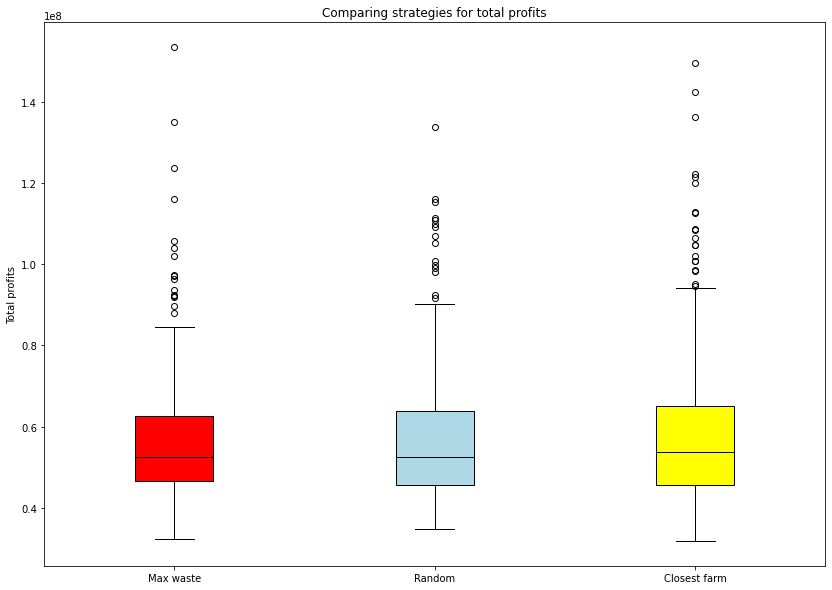

In [282]:
statistics_cal('profits', max_waste_total_profits, random_total_profits, closest_total_profits)
boxplot(max_waste_total_profits, random_total_profits, closest_total_profits)
plt.title("Comparing strategies for total profits")
plt.ylabel("Total profits")

Text(0, 0.5, 'frequency')

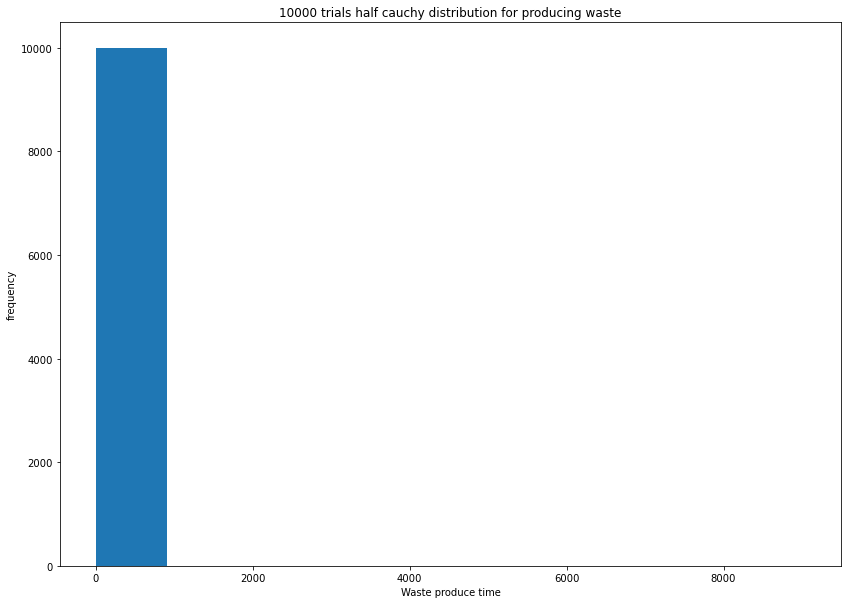

In [283]:
plt.hist(list(sts.halfcauchy(0,1).rvs(10000)))
plt.title("10000 trials half cauchy distribution for producing waste")
plt.xlabel("Waste produce time")
plt.ylabel("frequency")

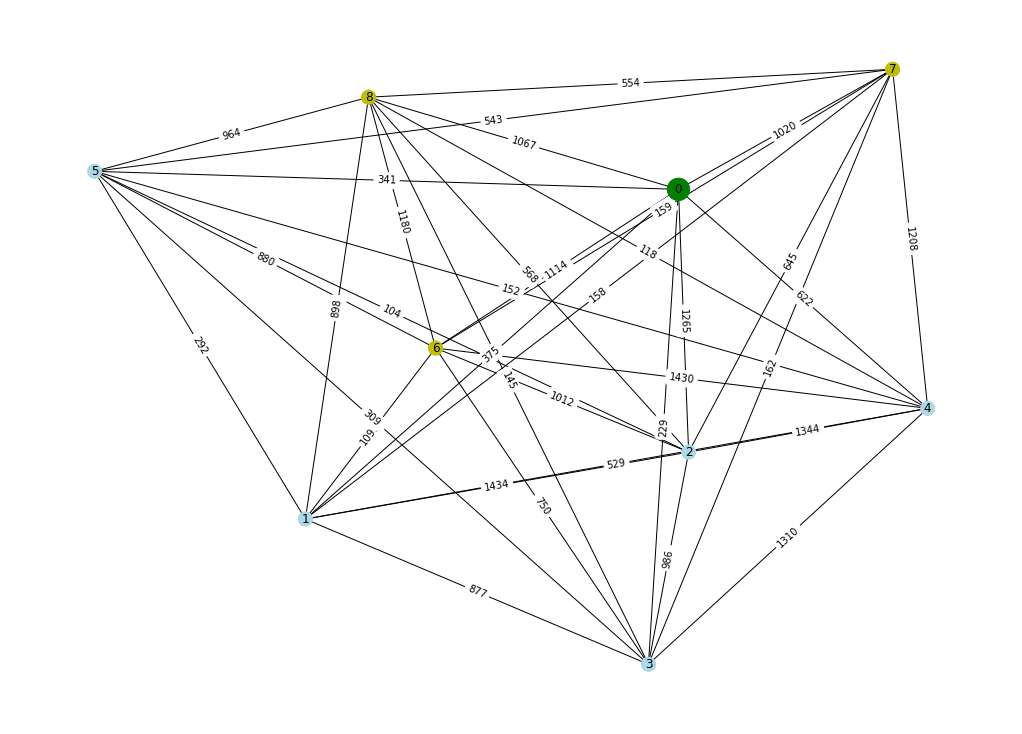

In [78]:
import random

random.seed(1)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

num_farms = 5
num_dropoff_sites = 3
n_trucks = 2


schedule = Schedule()
road_network = RoadNetwork(num_farms, num_dropoff_sites, n_trucks, strategy = 'max_waste')
road_network.run(schedule)
road_network.draw_network()


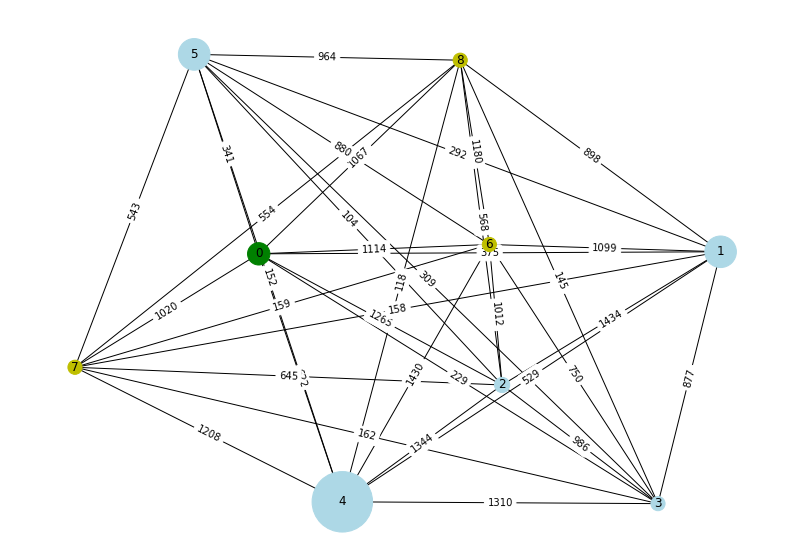

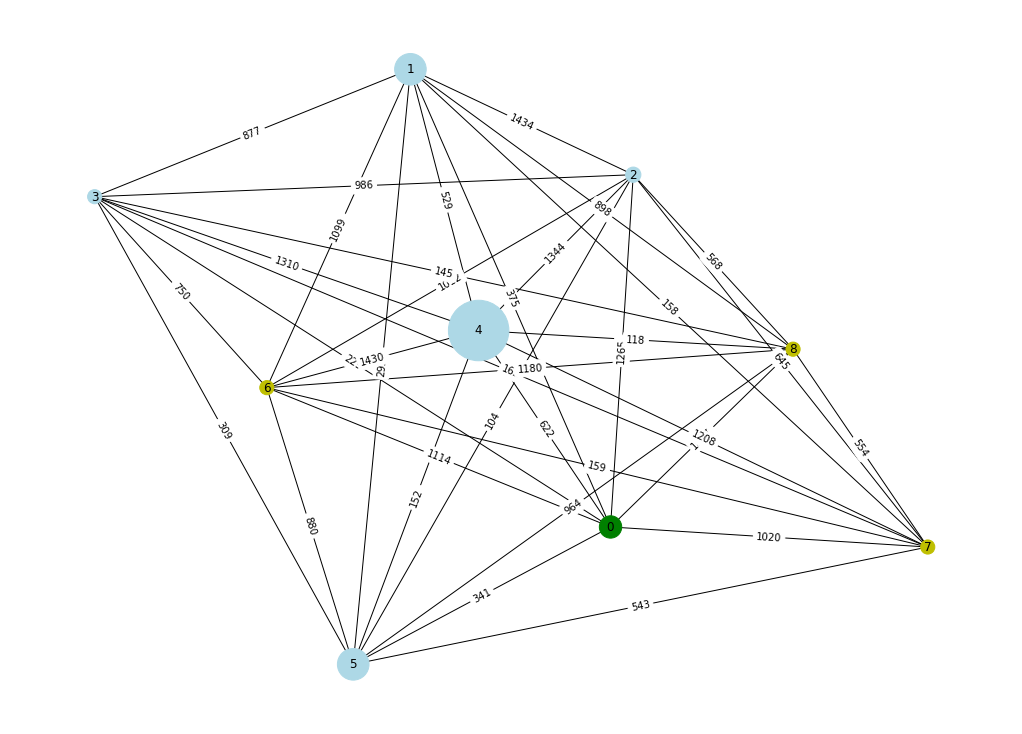

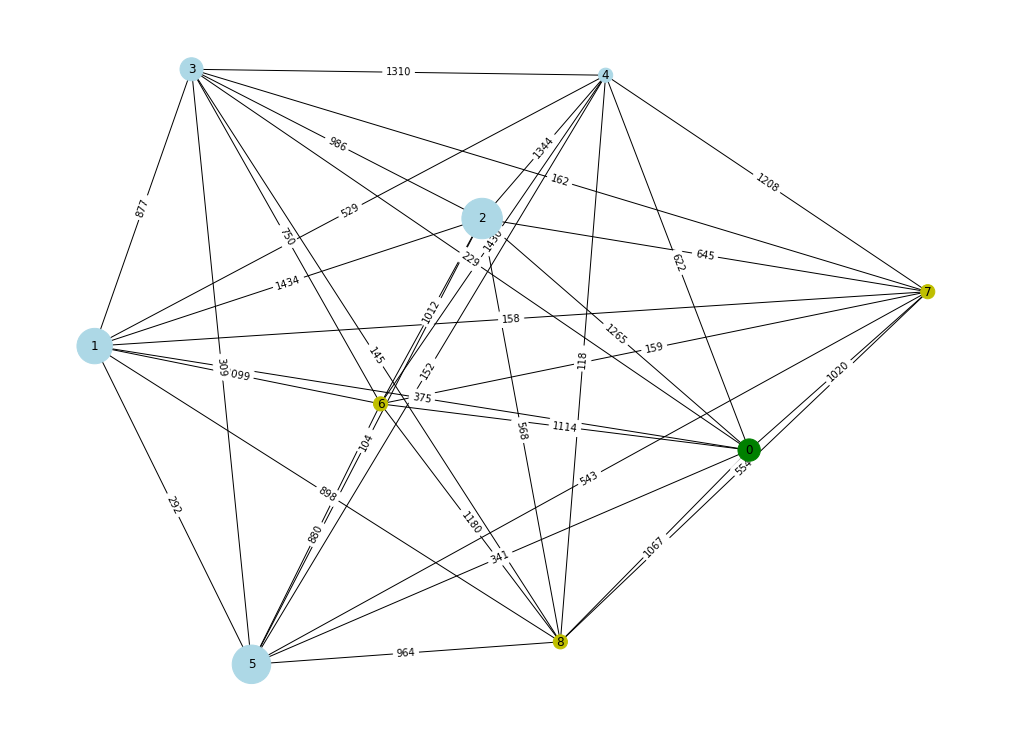

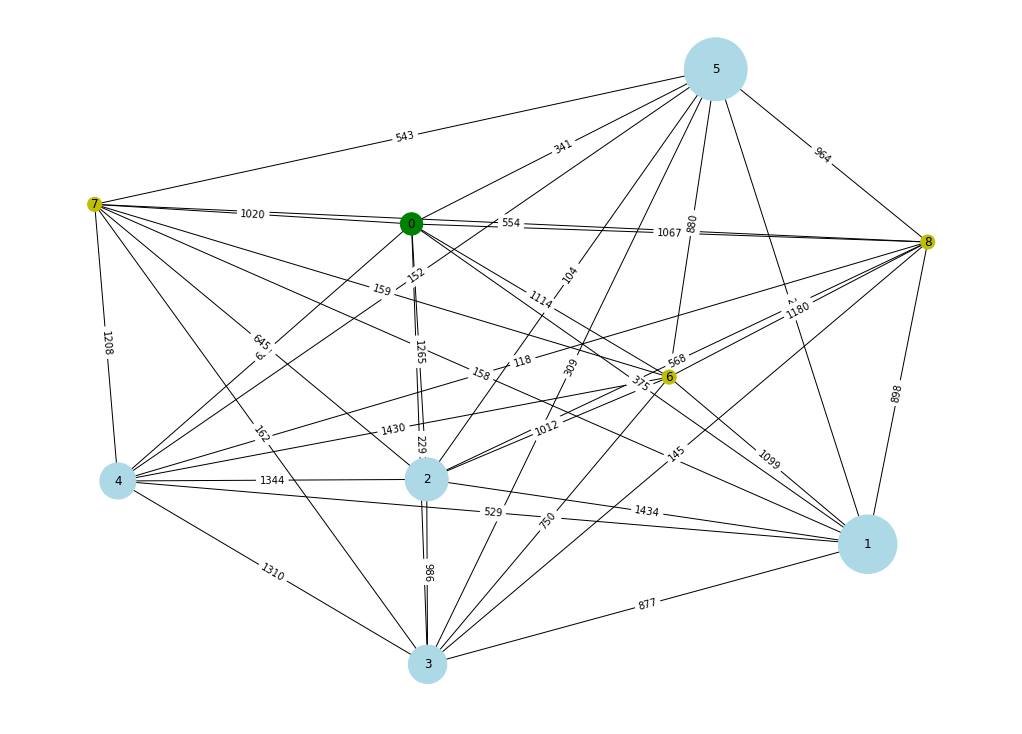

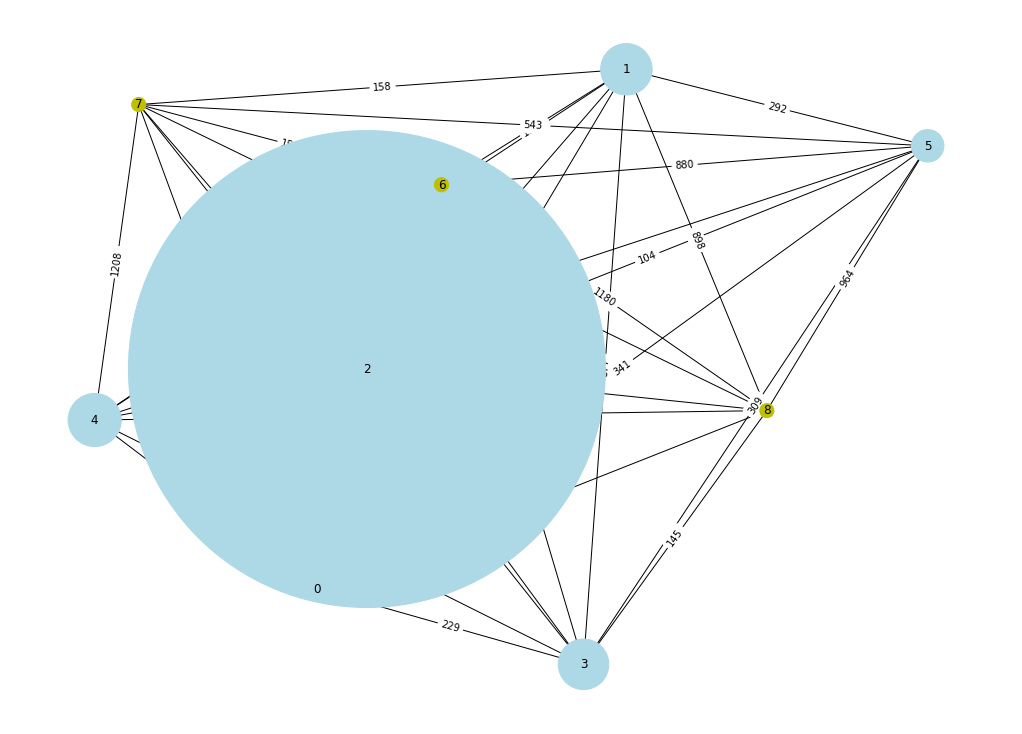

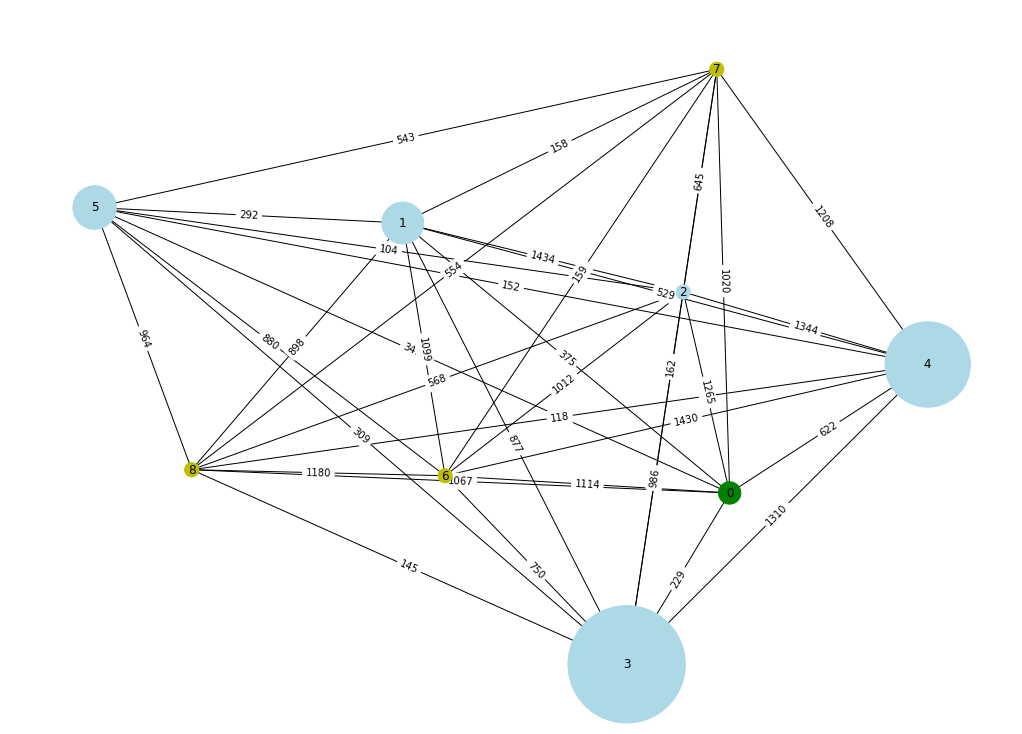

In [79]:
count = 0
def simple_update(n):
    while schedule.now <= n*10:
        schedule.run_next_event()      
    node_sizes = []
    for node_id in road_network.g.nodes: 
        if road_network.g.nodes[node_id]['n_type'] == 'farm':
            node_sizes.append(road_network.g.nodes[node_id]['obj'].waste * 100 + 200)
        elif road_network.g.nodes[node_id]['n_type'] == 'dropoff':
            node_sizes.append(200)
        elif road_network.g.nodes[node_id]['n_type'] == 'hq':
            node_sizes.append(500)

    pos = nx.spring_layout(road_network.g, scale=20, k=3/np.sqrt(road_network.g.order()), seed = 10)
    plot = nx.draw(road_network.g, pos, 
        with_labels=True, 
        node_color = [road_network.colors[road_network.g.nodes[i]['n_type']] for i in road_network.g.nodes], 
        node_size= node_sizes)
    edges_labels = nx.get_edge_attributes(road_network.g,'weight')
    nx.draw_networkx_edge_labels(road_network.g,pos,edge_labels=edges_labels)   
    plt.show()
    return plot

# for n in range(5): 
#     simple_update(n)

def simple_animation():
    fig, ax = plt.subplots()
    rcParams['figure.figsize'] = 14, 10
    ani = animation.FuncAnimation(fig, simple_update, frames = 5, interval = 500)
    output = HTML(ani.to_html5_video())
    return output


simple_animation()

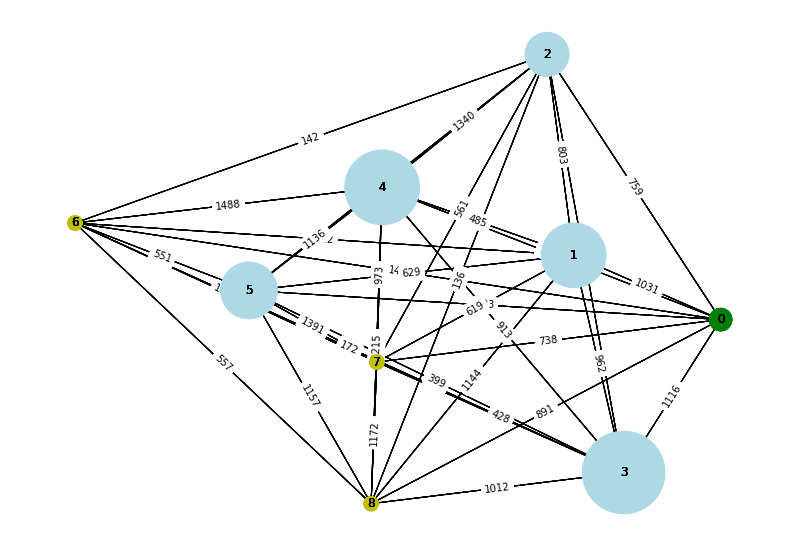

In [84]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

num_farms = 5
num_dropoff_sites = 3
n_trucks = 2


schedule = Schedule()
road_network = RoadNetwork(num_farms, num_dropoff_sites, n_trucks, strategy = 'max_waste')
road_network.run(schedule)


def simple_update(n):
    run = 0 
    while schedule.now <= n*5:
        schedule.run_next_event()      
    node_sizes = []
    for node_id in road_network.g.nodes: 
        if road_network.g.nodes[node_id]['n_type'] == 'farm':
            node_sizes.append(road_network.g.nodes[node_id]['obj'].waste * 100 + 200)
        elif road_network.g.nodes[node_id]['n_type'] == 'dropoff':
            node_sizes.append(200)
        elif road_network.g.nodes[node_id]['n_type'] == 'hq':
            node_sizes.append(500)

    pos = nx.spring_layout(road_network.g, scale=20, k=3/np.sqrt(road_network.g.order()), seed = 10)
    nx.draw(road_network.g, pos, 
        with_labels=True, 
        node_color = [road_network.colors[road_network.g.nodes[i]['n_type']] for i in road_network.g.nodes], 
        node_size= node_sizes)
    edges_labels = nx.get_edge_attributes(road_network.g,'weight')
    plot = nx.draw_networkx_edge_labels(road_network.g,pos,edge_labels=edges_labels)   
    return plot


def simple_animation():
    fig, ax = plt.subplots()
    rcParams['figure.figsize'] = 14, 10
    ani = animation.FuncAnimation(fig, simple_update, frames = 5)
    output = HTML(ani.to_html5_video())
    return output



simple_animation()